Aquí irá el portafolio de Blumenkron

#Introducción

Los incendios forestales han sido un fenómeno que ha afectado de diversas maneras a las personas al rededor del mundo

In [93]:
import os, shutil, pathlib
from keras.applications import ResNet50 #type: ignore
from keras.utils import to_categorical #type: ignore
from keras.utils import image_dataset_from_directory #type: ignore
from keras.models import Sequential
from keras import layers
from tensorflow import keras
from sklearn.datasets import load_sample_image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

class_names = ["Fire","No Fire"]

base_dir = pathlib.Path("the_wildfire_dataset_2n_version")


train_dataset = image_dataset_from_directory(
    base_dir / "train",
    image_size=(180, 180),
    batch_size=32,
   label_mode="int",
    )

validation_dataset = image_dataset_from_directory(
    base_dir / "val",
    image_size=(180, 180),
    batch_size=32,
    label_mode="int")

test_dataset = image_dataset_from_directory(
    base_dir / "test",
    image_size=(180, 180),
    batch_size=32,
    label_mode="int")


Found 1887 files belonging to 2 classes.
Found 402 files belonging to 2 classes.
Found 410 files belonging to 2 classes.


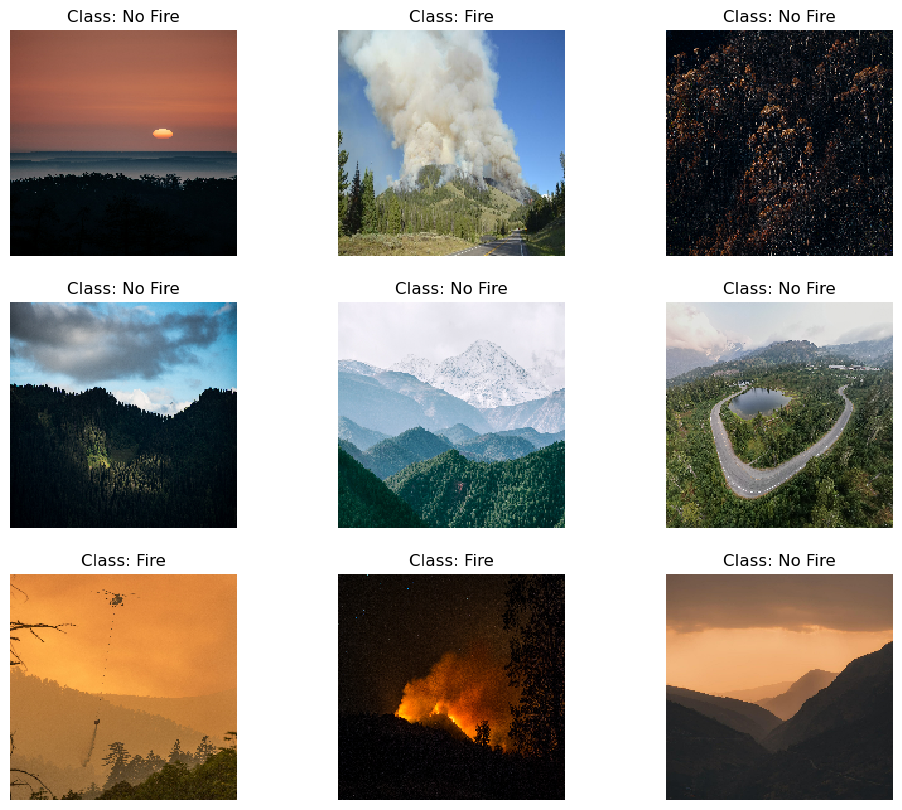

In [94]:
plt.figure(figsize=(12, 10))
index = 0
for element in train_dataset.take(1):
  for i in range(9):
    image = element[0][i]
    label = element[1][i]
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image/255, interpolation="nearest")
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")

plt.show()

Se inicializa el modelo ResNetr50 pero sin la capa de arriba, ya que nosotros queremos indicarle que clases son las que el modelo debe manejar para hacer las predicciones

In [95]:
modelo_base = ResNet50(weights='imagenet', include_top=False)
modelo_base.trainable = False

In [96]:
# Crear un nuevo modelo
model_final = Sequential([
    modelo_base,
    layers.GlobalAveragePooling2D(),  # Esta capa reduce la dimensionalidad
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Cambia 2 por el número de clases que tengas
])


In [97]:
model_final.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

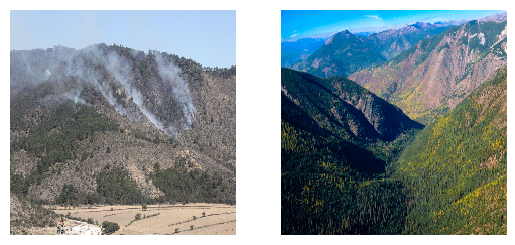

In [98]:
fire = keras.utils.load_img('the_wildfire_dataset_2n_version/test/fire/8468567365_18760a6d8b_o.jpg', target_size=(224,224))
no_fire = keras.utils.load_img('the_wildfire_dataset_2n_version/test/nofire/23289748533_1a14a0f249_o.jpg', target_size=(224,224))

fire_array = np.array(fire)
no_fire_array = np.array(no_fire)

images = np.array([fire_array, no_fire_array])

plt.subplot(121)
plt.imshow(images[0]/255, interpolation="nearest")
plt.axis("off")
plt.subplot(122)
plt.imshow(images[1]/255, interpolation="nearest")
plt.axis("off")
plt.show()

In [99]:
# Entrenar el modelo
history = model_final.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=10  # Ajusta el número de épocas según sea necesario
)


Epoch 1/10
59/59 [==============================] - 90s 1s/step - loss: 0.4825 - accuracy: 0.7843 - val_loss: 0.3468 - val_accuracy: 0.8507
Epoch 2/10
59/59 [==============================] - 83s 1s/step - loss: 0.2977 - accuracy: 0.8755 - val_loss: 0.2731 - val_accuracy: 0.8657
Epoch 3/10
59/59 [==============================] - 82s 1s/step - loss: 0.2620 - accuracy: 0.8903 - val_loss: 0.2700 - val_accuracy: 0.9005
Epoch 4/10
59/59 [==============================] - 83s 1s/step - loss: 0.2167 - accuracy: 0.9104 - val_loss: 0.2556 - val_accuracy: 0.8905
Epoch 5/10
59/59 [==============================] - 85s 1s/step - loss: 0.1878 - accuracy: 0.9274 - val_loss: 0.2529 - val_accuracy: 0.8980
Epoch 6/10
59/59 [==============================] - 84s 1s/step - loss: 0.1675 - accuracy: 0.9316 - val_loss: 0.2616 - val_accuracy: 0.8955
Epoch 7/10
59/59 [==============================] - 84s 1s/step - loss: 0.1635 - accuracy: 0.9353 - val_loss: 0.2439 - val_accuracy: 0.9055
Epoch 8/10
59/59 [==

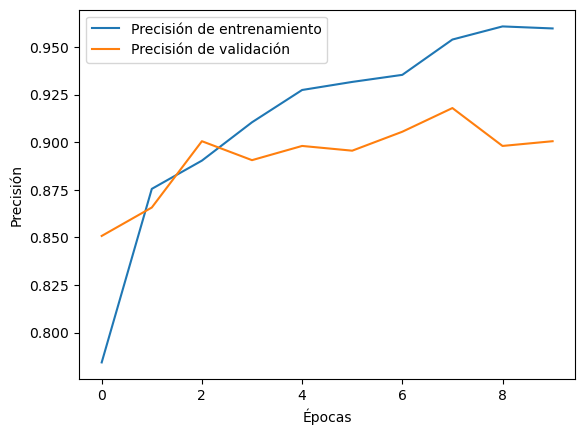

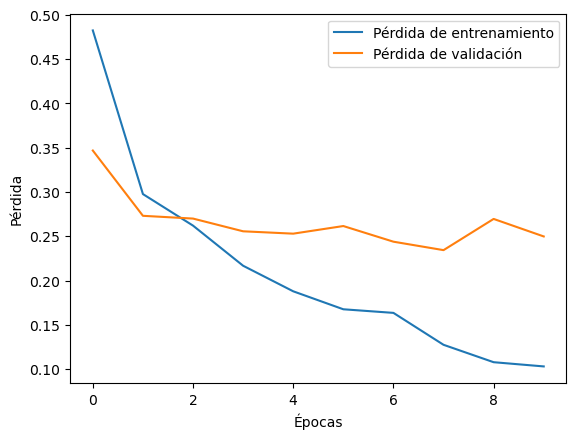

In [100]:
import matplotlib.pyplot as plt

# Gráfica de precisión
plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()

# Gráfica de pérdida
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()


In [101]:
# Hacer predicciones en el conjunto de prueba
predictions = model_final.predict(test_dataset)

# Las predicciones son probabilidades, puedes convertirlas a clases
predicted_classes = (predictions > 0.5).astype(int) 

13/13 [==============================] - 14s 619ms/step


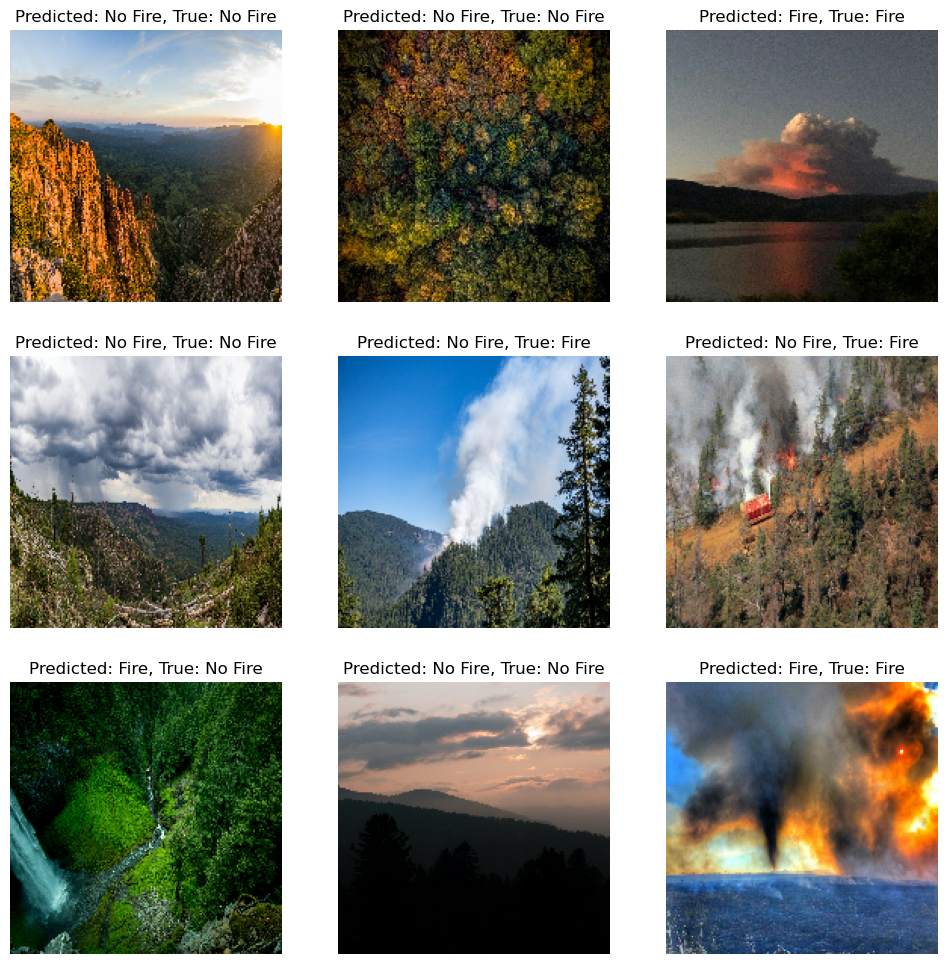

In [102]:
import matplotlib.pyplot as plt

# Función para visualizar imágenes y sus predicciones
def plot_predictions(dataset, predicted_classes, class_names):
    plt.figure(figsize=(12, 12))
    for images, labels in dataset.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(f"Predicted: {class_names[predicted_classes[i][0]]}, True: {class_names[labels[i]]}")
            plt.axis("off")
    plt.show()

# Visualizar algunas predicciones
plot_predictions(test_dataset, predicted_classes, class_names)


In [103]:
# Evaluar el modelo en el conjunto de prueba
test_loss, test_accuracy = model_final.evaluate(test_dataset)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


13/13 [==============================] - 13s 664ms/step - loss: 0.1871 - accuracy: 0.9268
Test Loss: 0.18706992268562317, Test Accuracy: 0.9268292784690857
